# Betti Curve Plots 3.0 with AUC

Plots betti curves for *multiple* dgms profiles and includes AUC analysis

- Input: list of pickle files containing dgms (ripser output (np arrays)) up to H2
- Output: Betti curve plot & AUC metrics

Author: @emilyekstrum
<br> 11/17/25

In [ ]:
import pickle as pkl
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pandas as pd
#from scipy.integrate import trapz
from matplotlib.colors import to_rgb
import os
import glob
import re
import seaborn as sns


In [ ]:
#utils

def gaussian_smooth(y, sigma=2.0):
    """Apply Gaussian smoothing to Betti curves
    Args:
        y (np.ndarray): Input Betti curve values.
        sigma (float): Standard deviation for Gaussian kernel.
    Returns:
        np.ndarray: Smoothed Betti curve values."""
    
    if sigma <= 0:
        return y
    try:
        return gaussian_filter1d(y, sigma=sigma, mode="nearest")
    except Exception:
        # or use a simple convolution kernel
        radius = int(max(1, round(3 * sigma)))
        xs = np.arange(-radius, radius + 1, dtype=float)
        kernel = np.exp(-0.5 * (xs / sigma) ** 2)
        kernel /= kernel.sum()
        return np.convolve(y, kernel, mode="same")


def safe_min(arr):
    """ Compute min ignoring non-finite values.
    Args: 
        arr (np.ndarray): Input array.
    Returns:
        float: Minimum finite value or 0.0 if none exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.min(arr) if arr.size else 0.0


def safe_max(arr):
    """ compute max ignoring non-finite values
    Args:
        arr (np.ndarray): Input array.
    Returns:
        float: Maximum finite value or 1.0 if none exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.max(arr) if arr.size else 1.0


def normalize_grid(dgms, n_bins=600):
    """Compute normalized filtration grid across all dimensions.
    
    Args:
        dgms (list of np.ndarray): List of persistence diagrams for each dimension.
        n_bins (int): Number of bins for the grid.
    Returns:
        tuple: (normalized_grid, original_grid, t_min, t_max)
            normalized_grid (np.ndarray): Normalized grid [0,1].   
            original_grid (np.ndarray): Filtration values corresponding to normalized_grid.
            t_min (float): Minimum filtration value.
            t_max (float): Maximum filtration value."""
    
    # flatten one level if dgms is a list-of-lists 
    flattened = []
    for item in dgms:
        if item is None:
            continue
        # if it is a numpy array representing a diagram, append it
        if isinstance(item, np.ndarray):
            flattened.append(item)
            continue
        # If it is a list/tuple and its first element looks like a diagram (array-like),
        # treat it as a collection of diagrams and extend
        if isinstance(item, (list, tuple)) and len(item) > 0 and not isinstance(item[0], (int, float)):
            if isinstance(item[0], (list, tuple, np.ndarray)):
                flattened.extend(item)
                continue
        # or append the item itself
        flattened.append(item)

    births, deaths = [], []
    for dgm in flattened:
        if dgm is None:
            continue
        arr = np.asarray(dgm)
        if arr.size == 0:
            continue

        # handle single interval stored as 1D array [birth, death]
        if arr.ndim == 1:
            if arr.shape[0] >= 2:
                births.append(np.array([arr[0]], dtype=float))
                deaths.append(np.array([arr[1]], dtype=float))
            continue

        # should be a 2D array: N x 2 (birth, death)
        if arr.shape[1] >= 2:
            births.append(arr[:, 0].astype(float))
            deaths.append(arr[:, 1].astype(float))

    births = np.concatenate(births) if births else np.array([0.0])
    deaths_all = np.concatenate(deaths) if deaths else np.array([1.0])

    t_min = safe_min(births)
    t_max = safe_max(deaths_all)
    if not np.isfinite(t_max):
        t_max = t_min + 1.0

    normalized_grid = np.linspace(0.0, 1.0, n_bins)
    original_grid = t_min + normalized_grid * (t_max - t_min)
    return normalized_grid, original_grid, t_min, t_max


def betti_curve_for_dim(dgm, original_grid):
    """Compute Betti(t) = # intervals alive at each t.
    Args:
        dgm (np.ndarray): Persistence diagram for a single homology dimension.
        original_grid (np.ndarray): Filtration values at which to compute Betti numbers.
    Returns:
        np.ndarray: Betti numbers at each t in original_grid."""
    
    if dgm is None or len(dgm) == 0:
        return np.zeros_like(original_grid)
    arr = np.asarray(dgm)
    if arr.ndim == 1:
        # single interval
        births = np.array([arr[0]])
        deaths = np.array([arr[1]]) if arr.shape[0] > 1 else np.array([np.inf])
    else:
        births, deaths = arr[:, 0], arr[:, 1]

    alive = (births[:, None] <= original_grid[None, :]) & (
        np.isinf(deaths[:, None]) | (deaths[:, None] > original_grid[None, :])
    )
    return alive.sum(axis=0)


def load_dgms(pkl_path):
    """Load persistence diagrams (H0, H1, H2) from pickle file.
    Args:
        pkl_path (Path or str): Path to the pickle file.
    Returns:
        list of np.ndarray: List containing H0, H1, H2 diagrams."""
    
    with open(pkl_path, "rb") as f:
        obj = pkl.load(f)
    if isinstance(obj, (list, tuple)) and len(obj) >= 3:
        return [np.asarray(obj[0]), np.asarray(obj[1]), np.asarray(obj[2])]
    if isinstance(obj, dict):
        if "dgms" in obj:
            dgms = obj["dgms"]
            if isinstance(dgms, (list, tuple)) and len(dgms) >= 3:
                return [np.asarray(dgms[0]), np.asarray(dgms[1]), np.asarray(dgms[2])]
        found = []
        for k in (0, 1, 2):
            if k in obj:
                found.append(np.asarray(obj[k]))
        if len(found) == 3:
            return found
    raise ValueError("Pickle must contain (H0, H1, H2) arrays or dict with keys 0,1,2 or 'dgms'.")


def get_region_from_filename(filepath):
    """Extract region (V1 or LGN) from filename.
    Args:
        filepath (str or Path): File path to extract region from.
    Returns:
        str: 'V1', 'LGN', or 'Unknown'."""
    
    filepath = str(filepath).upper()
    if 'V1' in filepath:
        return 'V1'
    elif 'LGN' in filepath:
        return 'LGN'
    else:
        return 'Unknown'
    
def get_shuffled_from_filename(filepath):
    """Extract whether data is shuffled from filename.
    Args:
        filepath (str or Path): File path to extract shuffle info from.
    Returns:
        bool: True if 'shuffled' in filename, else False."""
    
    filepath = str(filepath).lower()
    if 'shuffled' in filepath:
        return True
    else:
        return False
    
def get_random_null_from_filename(filepath):
    """Extract whether data is random null from filename.
    Args:
        filepath (str or Path): File path to extract random null info from.
    Returns:
        bool: True if 'random' in filename, else False."""
    
    filepath = str(filepath).lower()
    if 'random' in filepath:
        return True
    else:
        return False
    
def get_dimension_from_filename(filepath):
    """Extract embedding dimension from filename.
    Args:
        filepath (str or Path): File path to extract dimension from.
    Returns:
        str: Dimension token ('3d', '8d', '24d', '32d') or 'unknown'."""
    
    filepath = str(filepath).lower()
    for dim in ['3d', '8d', '24d', '32d']:
        if dim in filepath:
            return dim
    return 'unknown'
    

def shade_color_toward_white(base_color, factor):
    """Return an RGB tuple blended between white and OG color for 
    dimension
    Args:
        base_color (str or tuple): Base color (e.g., 'blue' or (r,g,b)).
        factor (float): Blend factor between 0.0 (white) and 1.0 (base color).
    Returns:
        tuple: Shaded RGB color."""

    base = np.array(to_rgb(base_color), dtype=float)
    white = np.array([1.0, 1.0, 1.0], dtype=float)
    shaded = base * factor + white * (1.0 - factor)
    return tuple(np.clip(shaded, 0.0, 1.0))


def compute_dim_shade_map(pickle_paths, darkest=1.0, lightest=0.35):
    """Return a mapping dim_token -> shade factor between [darkest, lightest].
    The dims are sorted numerically (3d,8d,24d,32d) so lower dims get darker shades.
    
    Args:
        pickle_paths (list of str): List of pickle file paths.
        darkest (float): Shade factor for darkest dimension.
        lightest (float): Shade factor for lightest dimension.
    Returns:
        dict: Mapping from dimension token to shade factor."""
    
    dims = []
    for p in pickle_paths:
        d = get_dimension_from_filename(p)
        if d not in dims:
            dims.append(d)

    def dim_key(s):
        try:
            return int(s[:-1]) if s.endswith('d') and s[:-1].isdigit() else float('inf')
        except Exception:
            return float('inf')

    dims_sorted = sorted(dims, key=dim_key)
    if len(dims_sorted) == 0:
        return {}
    alphas = np.linspace(darkest, lightest, len(dims_sorted))
    return {d: a for d, a in zip(dims_sorted, alphas)}


def plot_multiple_betti_curves(pickle_paths, bins=600, sigma=2.0, title=None, savepath=None):
    """Plot multiple Betti curves overlaid for region comparison.
    
    Args:
        pickle_paths (list of str): List of pickle file paths.
        bins (int): Number of bins for the Betti curve.
        sigma (float): Standard deviation for Gaussian smoothing.
        title (str or None): Plot title.
        savepath (str or None): Path to save the plot."""
    

    plt.figure(figsize=(10, 6))

    # Colors for each homology dimension
    dim_colors = ['blue', 'orange', 'green']
    labels = ["H0", "H1", "H2"]

    # Process all files and get dgms
    all_dgms = [load_dgms(Path(path)) for path in pickle_paths]

    # compute per-dimension shade mapping (3d darkest, then 8d, 24d, 32d lighter)
    dim_to_alpha = compute_dim_shade_map(pickle_paths, darkest=1.0, lightest=0.35)

    seen_legend = set()

    # Plot curves for each file
    for i, pickle_path in enumerate(pickle_paths):
        region = get_region_from_filename(pickle_path)
        shuffled = get_shuffled_from_filename(pickle_path)
        random = get_random_null_from_filename(pickle_path)
        dimension = get_dimension_from_filename(pickle_path)

        dgms = all_dgms[i]
        s_grid, t_grid, t_min, t_max = normalize_grid(dgms, n_bins=bins)

        # Set line style based on shuffled/random
        linestyle = '--' if (shuffled or random) else '-'

        alpha = dim_to_alpha.get(dimension, 0.6)

        for dim_idx, (label, dgm, base_color) in enumerate(zip(labels, dgms, dim_colors)):
            y = betti_curve_for_dim(dgm, t_grid)
            y_smooth = gaussian_smooth(y, sigma=sigma)
            color_shade = shade_color_toward_white(base_color, alpha)

            legend_label = f"{dimension} {label}"
            use_label = legend_label if legend_label not in seen_legend else None
            if use_label is not None:
                seen_legend.add(legend_label)

            plt.plot(s_grid, y_smooth, linestyle=linestyle, color=color_shade, linewidth=2, label=use_label)

    plt.xlabel("ε (Filtration Diameter)")
    plt.ylabel("Betti numbers (Number of holes/cycles)")
    plt.xlim(0, 1) #t_max, 0.1 for real
    #plt.ylim(0, 1)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
        print(f"Saved plot to {savepath}")
    plt.show()


def calculate_auc_for_betti_curves(pickle_paths, bins=600, sigma=2.0):
    """Calculate AUC for each Betti curve (each file × each homology dimension).

    Args:
        pickle_paths (list of str): List of pickle file paths.
        bins (int): Number of bins for the Betti curve.
        sigma (float): Standard deviation for Gaussian smoothing.
    Returns:
        dict: Dictionary with keys (file_index, dimension) -> AUC value
        list: List of dictionaries with detailed info for each curve
    """
    
    all_dgms = [load_dgms(Path(path)) for path in pickle_paths]

    # flatten diagrams across files and homology dimensions so normalize_grid
    # takes an iterable of diagrams
    flattened = [d for dgms in all_dgms for d in dgms]
    normalized_grid, original_grid, t_min, t_max = normalize_grid(flattened, n_bins=bins)
    
    dim_labels = ["H0", "H1", "H2"]
    auc_results = {}
    detailed_results = []
    
    for i, pickle_path in enumerate(pickle_paths):
        region = get_region_from_filename(pickle_path)
        shuffled = get_shuffled_from_filename(pickle_path)
        random = get_random_null_from_filename(pickle_path)
        dimension = get_dimension_from_filename(pickle_path)
        
        dgms = all_dgms[i]
        
        for dim_idx, (label, dgm) in enumerate(zip(dim_labels, dgms)):
            # Compute Betti curve
            y = betti_curve_for_dim(dgm, original_grid)
            y_smooth = gaussian_smooth(y, sigma=sigma)
            
            # Calculate AUC over normalized_grid
            auc_value = np.trapz(y_smooth, normalized_grid)
            
            # store results
            key = (i, dim_idx)
            auc_results[key] = auc_value
            
            # really detailed output 
            detailed_results.append({
                'file_index': i,
                'filename': Path(pickle_path).name,
                'region': region,
                'dimension': dimension,
                'homology_dim': label,
                'shuffled': shuffled,
                'random': random,
                'auc': auc_value
            })
    
    return auc_results, detailed_results



## Specify file paths

In [ ]:

# can specify specific parameters about files here or manually input file paths
region = "V1"
mouse = "C159"
stim = "drifting_gratings"
stim_short = "dg"

pickle_files = [
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\3d\{region}\CEBRA_3d_{region}_{stim_short}_{mouse}.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\8d\{region}\CEBRA_8d_{region}_{stim_short}_{mouse}.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\24d\{region}\CEBRA_24d_{region}_{stim_short}_{mouse}.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\32d\{region}\CEBRA_32d_{region}_{stim_short}_{mouse}.pkl",
]

shuffled_pickle_files = [
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\3d\{region}\{region}_3d_shuffled_{stim}_{mouse}_dgms.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\8d\{region}\{region}_8d_shuffled_{stim}_{mouse}_dgms.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\24d\{region}\{region}_24d_shuffled_{stim}_{mouse}_dgms.pkl",
    fr"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\32d\{region}\{region}_32d_shuffled_{stim}_{mouse}_dgms.pkl",
]
# pickle_files = [
#     r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\3d_shared_relu_dgms.pkl",
#     r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\8d_shared_relu_dgms.pkl",
#     r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\24d_shared_relu_dgms.pkl",
#     r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\32d_shared_relu_dgms.pkl",
# ]


## Usage

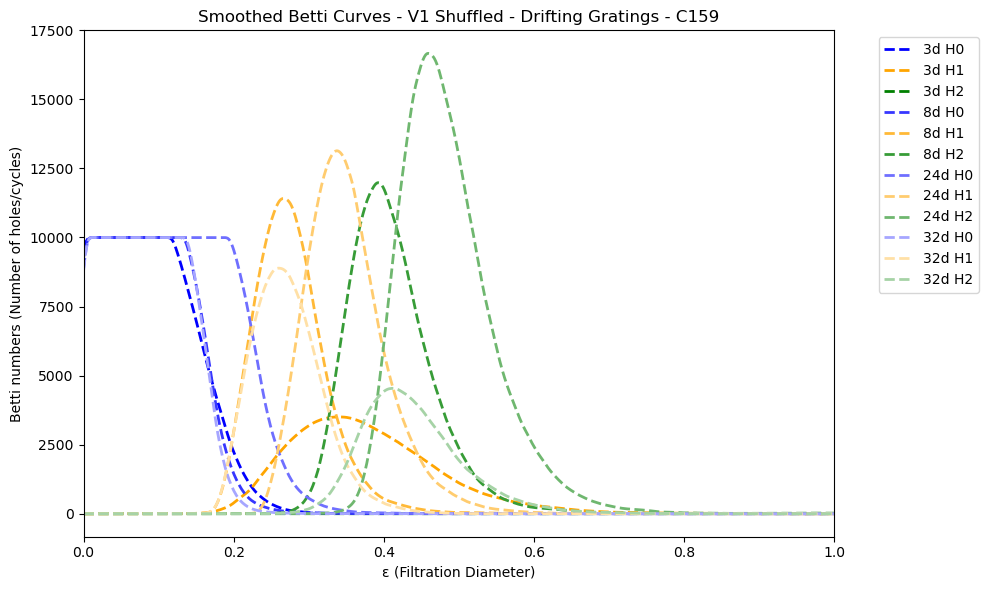

In [ ]:

plot_multiple_betti_curves(pickle_paths=shuffled_pickle_files, bins=600, sigma=2.0, title="Smoothed Betti Curves - V1 Shuffled - Drifting Gratings - C159",)

In [ ]:
# example - calculate AUC for each Betti curve
auc_dict, detailed_results = calculate_auc_for_betti_curves(pickle_paths=shuffled_pickle_files, bins=600, sigma=2.0)
df_auc = pd.DataFrame(detailed_results)

# print table w AUC values per betti curve
df_auc

,file_index,filename,region,dimension,homology_dim,shuffled,random,auc
0,0,V1_3d_shuffled_drifting_gratings_C159_dgms.pkl,V1,3d,H0,True,False,17.972454
1,0,V1_3d_shuffled_drifting_gratings_C159_dgms.pkl,V1,3d,H1,True,False,3.954090
2,0,V1_3d_shuffled_drifting_gratings_C159_dgms.pkl,V1,3d,H2,True,False,0.980801
3,1,V1_8d_shuffled_drifting_gratings_C159_dgms.pkl,V1,8d,H0,True,False,1456.215359
4,1,V1_8d_shuffled_drifting_gratings_C159_dgms.pkl,V1,8d,H1,True,False,1055.919866
5,1,V1_8d_shuffled_drifting_gratings_C159_dgms.pkl,V1,8d,H2,True,False,1253.243740
6,2,V1_24d_shuffled_drifting_gratings_C159_dgms.pkl,V1,24d,H0,True,False,2406.843907
7,2,V1_24d_shuffled_drifting_gratings_C159_dgms.pkl,V1,24d,H1,True,False,1593.387312
8,2,V1_24d_shuffled_drifting_gratings_C159_dgms.pkl,V1,24d,H2,True,False,2262.043406
9,3,V1_32d_shuffled_drifting_gratings_C159_dgms.pkl,V1,32d,H0,True,False,756.830551


## AUC plots

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_29564\1951985241.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, palette='rocket')
C:\Users\denmanlab\AppData\Local\Temp\ipykernel_29564\1951985241.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, palette='rocket')


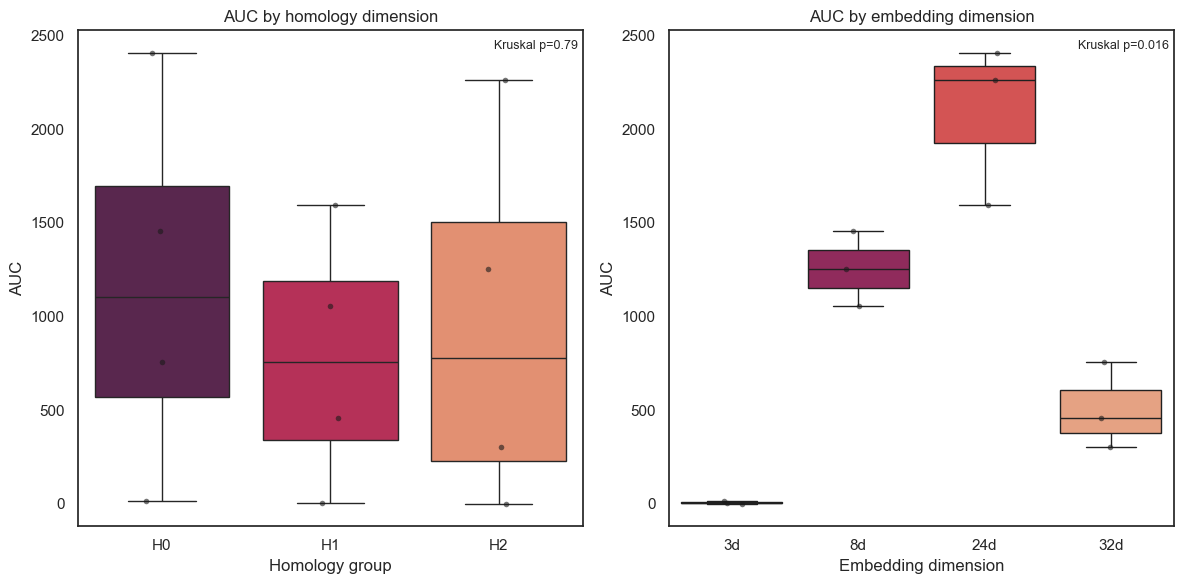

In [ ]:
try:
    import seaborn as sns
    sns.set(style="white")
except Exception:
    sns = None

import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools
import numpy as np

# p-value to star symbols function
def p_to_stars(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return 'ns'


if df_auc.empty:
    print('df_auc is empty.')
else:
    def dim_order_key(s):
        try:
            return int(s[:-1]) if isinstance(s, str) and s.endswith('d') and s[:-1].isdigit() else float('inf')
        except Exception:
            return float('inf')

    dim_order = sorted(df_auc['dimension'].unique(), key=dim_order_key)
    hom_order = sorted(df_auc['homology_dim'].unique())

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    ax00 = axes[0]
    ax01 = axes[1]

    # left plot: homology groups boxplot
    if sns is not None:
        sns.boxplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, palette='rocket')
        sns.stripplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, color='k', size=4, jitter=True, alpha=0.6)
    else:
        groups = df_auc.groupby('homology_dim')['auc'].apply(list)
        labels = list(groups.index)
        ax00.boxplot(groups.tolist(), labels=labels)

    # kruskal-wallis test across homology dims
    hom_groups = [df_auc[df_auc['homology_dim'] == g]['auc'].dropna().values for g in hom_order]
    try:
        kr_stat, kr_p = kruskal(*[g for g in hom_groups if len(g) > 0])
    except Exception:
        kr_p = 1.0
    ax00.set_title(f'AUC by homology dimension')
    ax00.set_xlabel('Homology group')
    ax00.set_ylabel('AUC')
    ax00.text(0.99, 0.98, f'Kruskal p={kr_p:.2g}', transform=ax00.transAxes, ha='right', va='top', fontsize=9)

    # right plot: embedding dimension boxplot
    if sns is not None:
        sns.boxplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, palette='rocket')
        sns.stripplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, color='k', size=4, jitter=True, alpha=0.6)
    else:
        groups2 = df_auc.groupby('dimension')['auc'].apply(list)
        labels2 = dim_order
        ax01.boxplot([groups2.get(l, []) for l in labels2], labels=labels2)

    emb_groups = [df_auc[df_auc['dimension'] == g]['auc'].dropna().values for g in dim_order]
    try:
        kr_stat2, kr_p2 = kruskal(*[g for g in emb_groups if len(g) > 0])
    except Exception:
        kr_p2 = 1.0
    ax01.set_title('AUC by embedding dimension')
    ax01.set_xlabel('Embedding dimension')
    ax01.set_ylabel('AUC')
    ax01.text(0.99, 0.98, f'Kruskal p={kr_p2:.2g}', transform=ax01.transAxes, ha='right', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

Found 60 pickle files under C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2 (using pattern **/*.pkl)


C:\Users\denmanlab\AppData\Local\Temp\ipykernel_29564\775045531.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(data=auc_df[auc_df['stim'].isin(show_stims)], x='dimension', y='auc', col='stim', col_wrap=4, order=dim_order, kind='box', palette='rocket', height=3.5, aspect=1.2)


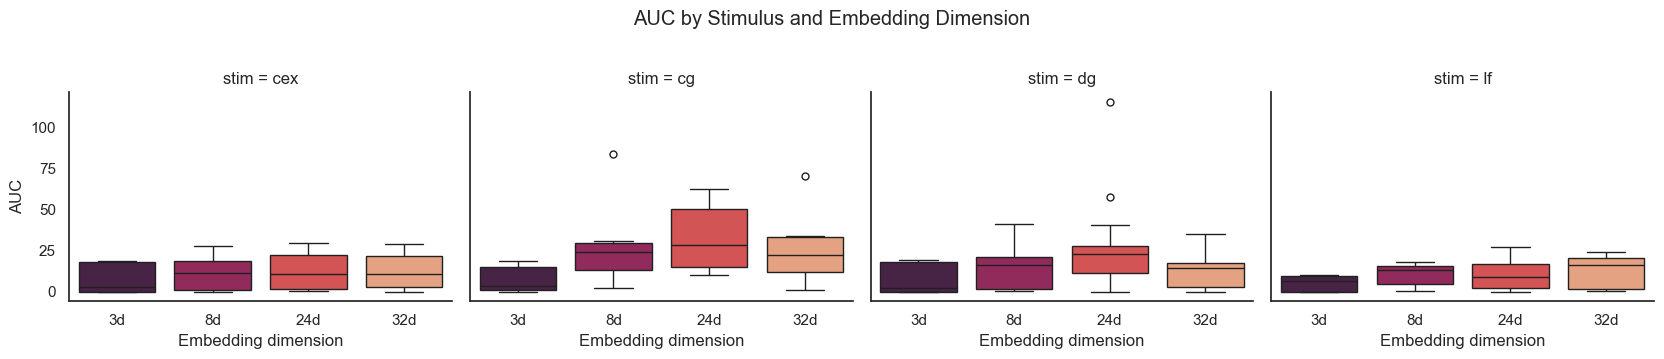

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_29564\775045531.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.catplot(data=auc_df[auc_df['stim'].isin(show_stims)], x='homology_dim', y='auc', col='stim', col_wrap=4, kind='box', palette='rocket', height=3.5, aspect=1.2)


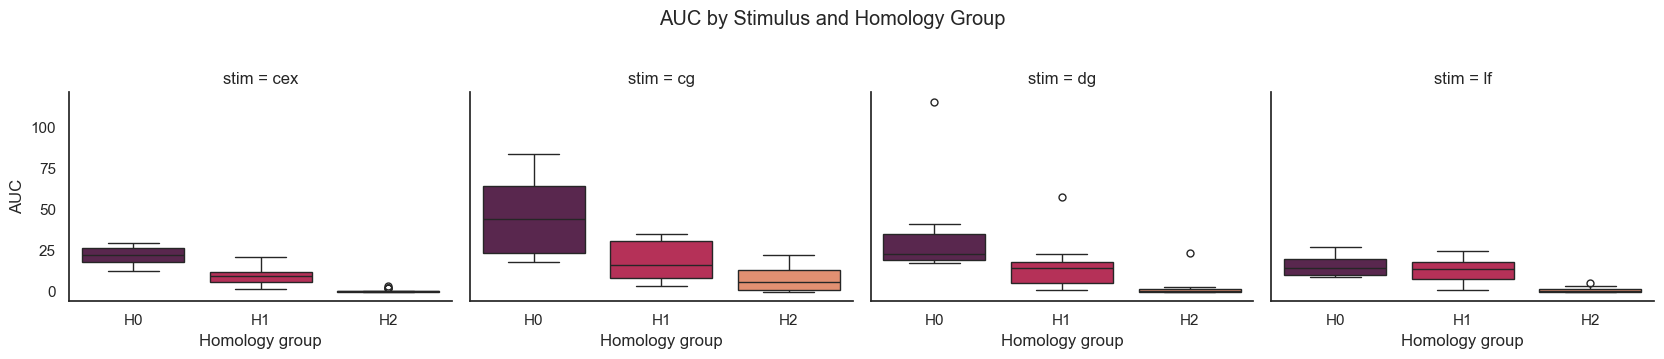

In [ ]:
# Compute and plot AUCs grouped by stimuli/dimension and stimuli/homology

def get_stim_from_filename(filepath):
    """Extract stimulus token from filename using strict tokens: cex, lf, dg, cg.
    Hey so chat helped out with this one so shoutout AI and take up any problems you have with 
    chat, not me"""

    fname = str(filepath).lower()

    # tokens to extract
    tokens = ['cex', 'lf', 'dg', 'cg']
    # regex to match whole-token boundaries (non-alphanumeric on either side or start/end)
    pattern = re.compile(r'(?<![0-9a-zA-Z])(' + '|'.join(tokens) + r')(?![0-9a-zA-Z])')
    m = pattern.search(fname)
    if m:
        return m.group(1)

    # longer words for stimuli -> map to tokens
    if re.search(r'drift|grate|grating|drifting', fname):
        return 'dg'
    if re.search(r'contrast|natural|movie|cex|spectrum', fname):
        return 'cex'
    if re.search(r'lf|lowfreq|low_freq', fname):
        return 'lf'
    if re.search(r'chrom|cg|color', fname):
        return 'cg'

    # or just split on non-alphanumeric and check parts
    parts = re.split(r'[^0-9a-zA-Z]+', os.path.basename(fname))
    for p in parts:
        pp = p.strip()
        if pp in tokens:
            return pp

    return 'unknown'


def load_paths_from_file(file_list_path=None, dir_path=None, pattern='*.pkl'):
    """Returns unique paths from a file list and/or a directory.
    
    Args:
        file_list_path (str or None): Path to text file containing list of file paths (one per line).
        dir_path (str or None): Directory path to search for files.
        pattern (str): Glob pattern to match files in dir_path.
    Returns:
        list of str: Unique file paths found."""
    
    paths = []
    if file_list_path is not None and os.path.exists(file_list_path):
        with open(file_list_path, 'r') as fh:
            for line in fh:
                p = line.strip()
                if p:
                    paths.append(p)
    if dir_path is not None and os.path.isdir(dir_path):
        # Use recursive glob so patterns like '**/*.pkl' work
        matches = glob.glob(os.path.join(dir_path, pattern), recursive=True)
        paths.extend(sorted(matches))
    seen = set()
    out = []
    for p in paths:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out


def compute_or_get_auc_df(pickle_paths=None, file_list_path=None, dir_path=None, pattern='**/*.pkl'):
    """ Compute AUC dataframe from given pickle paths or by loading paths from file/dir.
    
    Args:
        pickle_paths (list of str or None): List of pickle file paths. If None, will load from file_list_path or dir_path.
        file_list_path (str or None): Path to text file containing list of pickle paths (one per line).
        dir_path (str or None): Directory path to search for pickle files.
        pattern (str): Glob pattern to match pickle files in dir_path.
    Returns:
        pd.DataFrame: DataFrame containing AUC results with columns:
            ['file_index', 'filename', 'region', 'dimension', 'homology_dim', 'shuffled', 'random', 'auc', 'stim']"""
    
    #get paths
    if pickle_paths is None:
        pickle_paths = load_paths_from_file(file_list_path=file_list_path, dir_path=dir_path, pattern=pattern)
    if not pickle_paths:
        raise ValueError('No pickle paths provided or found.')

    # compute AUCs
    auc_results, detailed_results_local = calculate_auc_for_betti_curves(pickle_paths, bins=600, sigma=2.0)

    df = pd.DataFrame(detailed_results_local)
    df['stim'] = df['filename'].apply(get_stim_from_filename)
    df['dimension'] = df['dimension'].astype(str)
    try:
        df['region_token'] = df['filename'].apply(lambda x: get_region_from_filename(x))
    except Exception:
        df['region_token'] = df['filename'].apply(lambda x: os.path.basename(x).split('_')[0])
    return df

dgms_dir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2" # path to directory containing dgms pickle files
file_exten = '**/*.pkl'   # file extension

# Load paths and compute AUC dataframe
paths = load_paths_from_file(dir_path=dgms_dir, pattern=file_exten)
if not paths:
    # or use previous pickle files from above
    paths = globals().get('shuffled_pickle_files', [])

if not paths:
    raise RuntimeError('No dgms pickle files found. Please set dgms_dir or provide a file list.')
print(f'Found {len(paths)} pickle files under {dgms_dir} (using pattern {file_exten})')

auc_df = compute_or_get_auc_df(pickle_paths=paths)

# Normalize tokens/orders
try:
    def dim_key_fn(s):
        try:
            return int(s[:-1]) if isinstance(s, str) and s.endswith('d') and s[:-1].isdigit() else float('inf')
        except Exception:
            return float('inf')
    dim_order = sorted(auc_df['dimension'].unique(), key=dim_key_fn)
except Exception:
    dim_order = list(auc_df['dimension'].unique())

stimulus = ['Color Exchange', 'Chromatic Gratings', 'Drifting Gratings', 'Luminance Flash']

# AUC by stimuli and embedding dimension 
if auc_df.empty:
    print('No AUC data to plot.')
else:
    stims = sorted(auc_df['stim'].unique())
    if len(stims) > 4:
        show_stims = stims[:4]
    else:
        show_stims = stims

    try:
        plot = sns.catplot(data=auc_df[auc_df['stim'].isin(show_stims)], x='dimension', y='auc', col='stim', col_wrap=4, order=dim_order, kind='box', palette='rocket', height=3.5, aspect=1.2)
        plot.set_axis_labels('Embedding dimension', 'AUC')
        for ax in plot.axes.flatten():
            ax.set_xlabel('Embedding dimension')
            ax.set_ylabel('AUC')
        plot.fig.suptitle('AUC by Stimulus and Embedding Dimension', y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception:
        n = len(show_stims)
        rows, cols = 1, 4
        fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5*rows), squeeze=False)
        for i, stim in enumerate(show_stims):
            r = i // cols
            c = i % cols
            ax = axes[r, c]
            subset = auc_df[auc_df['stim'] == stim]
            groups = [subset[subset['dimension'] == d]['auc'].dropna().values for d in dim_order]
            ax.boxplot(groups, labels=dim_order)
            ax.set_title(stim)
            ax.set_xlabel('Embedding dimension')
            ax.set_ylabel('AUC')
        # hide other axes
        for j in range(n, rows*cols):
            r = j // cols
            c = j % cols
            axes[r, c].axis('off')
        plt.tight_layout()
        plt.show()

    # AUC by stimuli and homology group 
    try:
        plot2 = sns.catplot(data=auc_df[auc_df['stim'].isin(show_stims)], x='homology_dim', y='auc', col='stim', col_wrap=4, kind='box', palette='rocket', height=3.5, aspect=1.2)
        plot2.set_axis_labels('Homology group', 'AUC')
        for ax in plot2.axes.flatten():
            ax.set_xlabel('Homology group')
            ax.set_ylabel('AUC')
        plot2.fig.suptitle('AUC by Stimulus and Homology Group', y=1.02)

        plt.tight_layout()
        plt.show()
    except Exception:
        n = len(show_stims)
        rows, cols = 1, 4
        fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5*rows), squeeze=False)
        hom_labels = sorted(auc_df['homology_dim'].unique())
        for i, stim in enumerate(show_stims):
            r = i // cols
            c = i % cols
            ax = axes[r, c]
            subset = auc_df[auc_df['stim'] == stim]
            groups = [subset[subset['homology_dim'] == h]['auc'].dropna().values for h in hom_labels]
            ax.boxplot(groups, labels=stimulus)
            ax.set_title(stim)
            ax.set_xlabel('Homology group')
            ax.set_ylabel('AUC')
        for j in range(n, rows*cols):
            r = j // cols
            c = j % cols
            axes[r, c].axis('off')
        plt.tight_layout()
        plt.show()